In [1]:
import math

import matplotlib.pylab as plt
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import train_test_split

from pandas_util import gains_chart, lift_chart, normalize_columns

## Prediction error metrics from a model for Toyota car prices. Training and validation

In [2]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis.
car_df = pd.read_csv("./datasets/dmba/ToyotaCorolla.csv")
normalize_columns(car_df)
car_df.sample(5)

,id,model,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,...,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,parking_assistant,tow_bar
605,609,TOYOTA Corolla 1.3 16V SEDAN LINEA TERRA 4/5-D...,5950,68,1,1999,194545,Petrol,86,0,...,0,1,0,0,0,0,0,0,0,0
547,550,TOYOTA Corolla 1.4 16V VVT I HATCHB TERRA 2/3-...,9950,55,2,2000,44537,Petrol,97,0,...,0,1,1,0,0,1,0,1,0,1
342,345,TOYOTA Corolla 1.6 16V VVT I HATCHB G6 2/3-Doors,14950,42,3,2001,29640,Petrol,110,0,...,1,1,0,1,1,1,1,0,0,0
111,113,TOYOTA Corolla VERSO 2.0 D4D SOL (7) MPV,31275,4,5,2004,1500,Diesel,116,1,...,1,1,0,1,1,1,0,0,0,0
616,620,TOYOTA Corolla 2.0 DSL LIFTB LINEA TERRA 4/5-D...,9500,62,7,1999,147636,Diesel,72,0,...,0,1,0,0,0,1,0,0,0,0


In [3]:
# Create a list of predictor variables by removing output variables and text columns
exclude_columns = "price id model fuel_type color".split()
predictors = [s for s in car_df.columns if s not in exclude_columns]
outcome = "price"

In [4]:
# Partition data.
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.4, random_state=1
)

In [5]:
# Train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# Evaluate performance
# Training
def regression_summary(y_true, y_pred):
    return {
        "Root mean squared error (RMSE)": metrics.mean_squared_error(y_true, y_pred),
        "Mean absolute error (MAE)": metrics.mean_absolute_error(y_true, y_pred),
        "Max error": metrics.max_error(y_true, y_pred),
    }


regression_summary(train_y, reg.predict(train_X))

{'Root mean squared error (RMSE)': 1256776.8345910097,
 'Mean absolute error (MAE)': 811.6770003906788,
 'Max error': 6679.952359929979}

In [6]:
regression_summary(valid_y, reg.predict(valid_X))

{'Root mean squared error (RMSE)': 1910021.3911752158,
 'Mean absolute error (MAE)': 880.1396340851031,
 'Max error': 19983.225248097442}

<AxesSubplot:title={'center':'residual'}, xlabel='[data set]'>

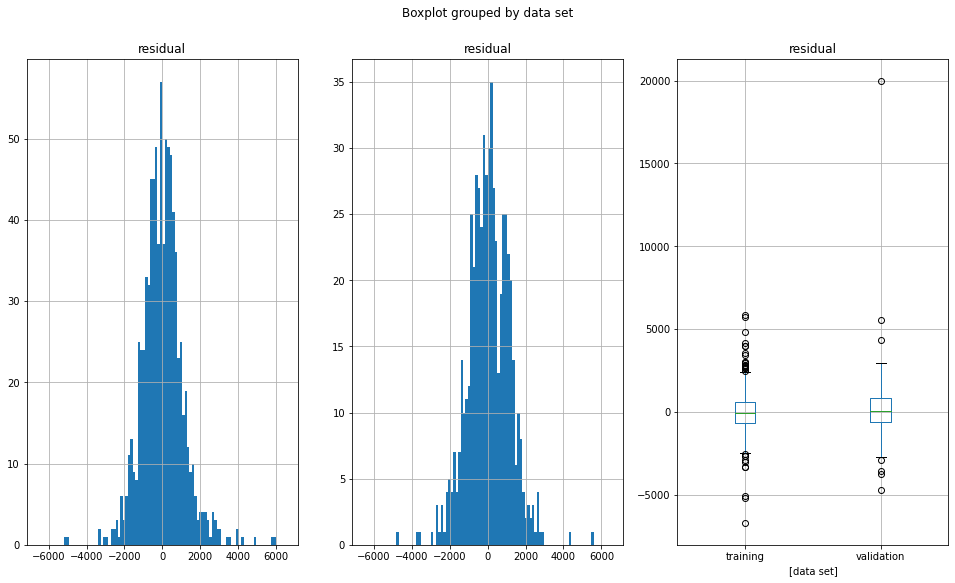

In [7]:
pred_error_train = pd.DataFrame(
    {"residual": train_y - reg.predict(train_X), "data set": "training"}
)
pred_error_valid = pd.DataFrame(
    {"residual": valid_y - reg.predict(valid_X), "data set": "validation"}
)
boxdata_df = pred_error_train.append(pred_error_valid, ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 9)
common = {"bins": 100, "range": [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by="data set")

In [8]:
# Histograms and boxplots of Toyota price prediction errors, for training and validation sets.

## Gain and lift charts


Gain and lift charts are visual aid for evaluating performance of classification models.


How does it differ from confusion matrix?
- confusion matrix: evaluates the overall population
- gain and lift chart: evaluates model performance in a portion of the population

In short, we evaluate the model in terms of benefit we could get using the model in a portion of the population.


Reference:
1.  https://towardsdatascience.com/model-benefit-evaluation-with-lift-and-gain-analysis-4b69f9288ab3#:~:text=Gain%20and%20lift%20charts%20are,a%20portion%20of%20the%20population.
2. http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
3. https://www.geeksforgeeks.org/understanding-gain-chart-and-lift-chart/
4. https://www.listendata.com/2014/08/excel-template-gain-and-lift-charts.html
5. https://select-statistics.co.uk/blog/cumulative-gains-and-lift-curves-measuring-the-performance-of-a-marketing-campaign/

In [9]:
# Difference between pd.qcut and pd.cut
# pd.cut partition equally by values
# pd.qcut partition equally by dataset

numbers = [
    1,
    1,
    1,
    2,
    2,
    3,
    4,
    5,
    6,
]
pd.qcut(numbers, 3, labels=False), pd.cut(numbers, 3, labels=False)

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 0, 0, 0, 0, 1, 1, 2, 2]))

In [10]:
pred_df = pd.DataFrame(reg.predict(valid_X), columns=["y_pred"], index=valid_X.index)
pred_df.sort_values(by="y_pred", ascending=False, inplace=True)

# Divide the data into deciles: divide the data into 10 sets and label it.
# qcut bins the data into different group. However, the largest values will be labelled decile 10 instead of 1, that is why we inverse the range.
pred_df["decile"] = pd.qcut(pred_df.y_pred, 10, labels=[i for i in range(10, 0, -1)])
lift_df = (
    pred_df.groupby("decile")
    .y_pred.agg(pred=("mean"), count=("count"))
    .reset_index()
    .sort_values("decile", ascending=False)
)
lift_df["decile_percent"] = lift_df.decile.astype(int) * 10
lift_df["cumulative"] = lift_df.pred.cumsum()
lift_df["gain"] = lift_df.cumulative / lift_df.cumulative.max() * 100
lift_df["lift"] = lift_df.gain / lift_df.decile_percent
lift_df

,decile,pred,count,decile_percent,cumulative,gain,lift
9,1,18514.313292,58,10,18514.313292,17.523277,1.752328
8,2,13551.618082,57,20,32065.931373,30.349502,1.517475
7,3,11923.397035,58,30,43989.328408,41.634662,1.387822
6,4,10778.656149,57,40,54767.984557,51.836357,1.295909
5,5,10191.693253,57,50,64959.677810,61.482508,1.229650
4,6,9587.440873,58,60,74547.118683,70.556751,1.175946
3,7,8917.324345,57,70,83464.443028,78.996748,1.128525
2,8,8253.960950,58,80,91718.403978,86.808890,1.085111
1,9,7547.928830,57,90,99266.332808,93.952792,1.043920
0,10,6389.210578,58,100,105655.543386,100.000000,1.000000


Text(0.5, 1.0, 'Gain Chart')

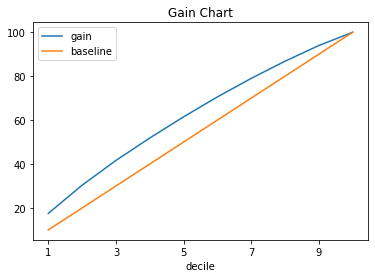

In [11]:
ax = lift_df.plot(x="decile", y=["gain", "decile_percent"])
ax.legend(["gain", "baseline"])
plt.title("Gain Chart")

Text(0.5, 1.0, 'Lift Chart')

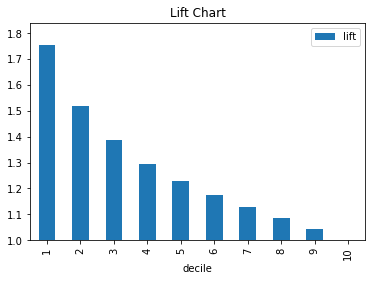

In [12]:
ax = lift_df.plot.bar(x="decile", y="lift")
ax.set_ylim(1)  # Start from 1
plt.title("Lift Chart")

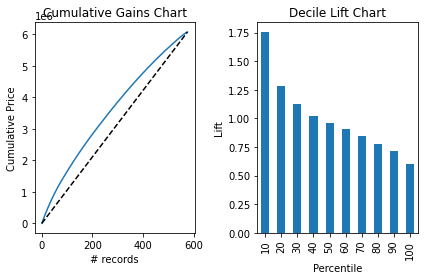

In [13]:
pred_v = pd.Series(reg.predict(valid_X))
pred_v = pred_v.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gains_chart(pred_v, ax=axes[0])
ax.set_ylabel("Cumulative Price")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()